In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/Deep_Learning/ # only once

In [ ]:
!cp -f curated-solubility-dataset.csv /content/drive/MyDrive/Deep_Learning/ # only once

In [ ]:
!pip -q install torch-geometric
!pip -q install pysmiles

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.4 MB/s eta 0:00:00


# Code

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

In [ ]:
logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

# Load dataset
data_frame = pd.read_csv('/content/drive/MyDrive/Deep_Learning/curated-solubility-dataset.csv')  # read dataset
smiles_list = list(data_frame['SMILES'])  # get smiles strings from file
solubility_values = np.asarray(data_frame['Solubility'])  # get solubility values from file

# List of all elements in the dataset
element_list = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
                'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
                'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
                'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
                'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
                'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

In [ ]:
# Convert element to a one-hot vector of dimension len(element_list)
def convert_element_to_onehot(element):
    onehot_output = []
    for i in range(len(element)):
        vector = np.zeros(len(element_list))
        vector[element_list.index(element[i])] = 1.0
        onehot_output.append(vector)
    return np.asarray(onehot_output)

# Convert solubility value to one-hot class vector
def convert_value_to_class(value):
    if value < -3.65:  # insoluble
        return [1, 0, 0]
    elif value < -1.69:  # slightly soluble
        return [0, 1, 0]
    else:  # soluble
        return [0, 0, 1]

# Process SMILES strings into graphs
node_features = []
edge_indices = []
for smiles in tqdm(smiles_list):
    try:
        graph = read_smiles(smiles, explicit_hydrogen=True)
        feature_vector = convert_element_to_onehot(np.asarray(graph.nodes(data='element'))[:, 1])
        edges = np.asarray(graph.edges)
        index_array = np.asarray([edges[:, 0], edges[:, 1]])  # reshape indices into shape [2, -1]
        node_features.append(feature_vector)
        edge_indices.append(index_array)
    except:
        pass


100%|██████████| 9982/9982 [00:51<00:00, 193.07it/s]


In [ ]:
# Generate Data objects
data_objects = []

# Process graphs into torch_geometric Data objects
for i in tqdm(range(len(node_features))):
    x_tensor = torch.tensor(node_features[i], dtype=torch.float)  # convert node features into torch tensor
    edges_tensor = torch.tensor(edge_indices[i], dtype=torch.long)  # convert edge index into torch tensor
    y_tensor = torch.tensor([convert_value_to_class(solubility_values[i])], dtype=torch.float)  # change shape of label and convert to tensor
    data_objects.append(Data(x=x_tensor, edge_index=edges_tensor, y=y_tensor))  # add the Data object to the list of data
random.shuffle(data_objects)
train_data = data_objects[:int(len(data_objects) * 0.8)]  # train set
test_data = data_objects[int(len(data_objects) * 0.8):]  # val set

100%|██████████| 9574/9574 [00:00<00:00, 17449.09it/s]


In [ ]:
# Defining the message passing network
class GraphNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNetwork, self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.fc1 = Linear(32, 16)
        self.fc2 = Linear(16, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)

        x = torch.sum(x, dim=0)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

In [ ]:
# Setting up the device and creating the graph network model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # use CUDA if available
model_instance = GraphNetwork().to(device)  # create network and send to the device memory
optimizer_instance = torch.optim.Adam(model_instance.parameters(), lr=0.001, weight_decay=1e-4)  # use Adam optimizer
loss_function = CrossEntropyLoss()  # define loss

In [ ]:
# Training model
model_instance.train()  # set model to training mode
for epoch in range(30):  # run for epochs of training
    total_loss = 0  # used to compute average loss in an epoch
    correct_predictions = 0
    random.shuffle(train_data)  # shuffle the training data each epoch
    for data_point in tqdm(train_data):  # go over each training point
        data_tensor = data_point.to(device)  # send data to device
        optimizer_instance.zero_grad()  # zero gradients
        output = model_instance(data_tensor)  # evaluate data point
        if torch.argmax(output) == torch.argmax(data_tensor.y):  # if prediction is correct, increment counter for accuracy calculation
            correct_predictions += 1
        loss_value = loss_function(torch.reshape(output, [1, 3]), torch.reshape(torch.argmax(data_tensor.y), [1]))  # compute mean squared error loss
        total_loss += float(loss_value)  # add loss value to aggregate loss
        loss_value.backward()  # compute gradients
        optimizer_instance.step()  # apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, total_loss / len(train_data), correct_predictions / len(train_data)))

100%|██████████| 7659/7659 [00:51<00:00, 149.23it/s]


Epoch: 000, Average loss: 1.10028, Accuracy: 0.33751


100%|██████████| 7659/7659 [00:46<00:00, 166.38it/s]


Epoch: 001, Average loss: 1.09663, Accuracy: 0.34913


100%|██████████| 7659/7659 [00:44<00:00, 172.67it/s]


Epoch: 002, Average loss: 1.09605, Accuracy: 0.36101


100%|██████████| 7659/7659 [00:44<00:00, 173.62it/s]


Epoch: 003, Average loss: 1.09520, Accuracy: 0.36454


100%|██████████| 7659/7659 [00:43<00:00, 176.02it/s]


Epoch: 004, Average loss: 1.09545, Accuracy: 0.36924


100%|██████████| 7659/7659 [00:43<00:00, 177.76it/s]


Epoch: 005, Average loss: 1.09526, Accuracy: 0.36676


100%|██████████| 7659/7659 [00:43<00:00, 174.47it/s]


Epoch: 006, Average loss: 1.09482, Accuracy: 0.35932


100%|██████████| 7659/7659 [00:43<00:00, 177.56it/s]


Epoch: 007, Average loss: 1.09452, Accuracy: 0.36924


100%|██████████| 7659/7659 [00:42<00:00, 178.66it/s]


Epoch: 008, Average loss: 1.09536, Accuracy: 0.36689


100%|██████████| 7659/7659 [00:43<00:00, 175.77it/s]


Epoch: 009, Average loss: 1.09713, Accuracy: 0.34639


100%|██████████| 7659/7659 [00:43<00:00, 175.94it/s]


Epoch: 010, Average loss: 1.09655, Accuracy: 0.35618


100%|██████████| 7659/7659 [00:42<00:00, 178.41it/s]


Epoch: 011, Average loss: 1.09909, Accuracy: 0.34130


100%|██████████| 7659/7659 [00:43<00:00, 175.53it/s]


Epoch: 012, Average loss: 1.09915, Accuracy: 0.33346


100%|██████████| 7659/7659 [00:42<00:00, 178.16it/s]


Epoch: 013, Average loss: 1.09880, Accuracy: 0.33529


100%|██████████| 7659/7659 [00:43<00:00, 178.04it/s]


Epoch: 014, Average loss: 1.09912, Accuracy: 0.32824


100%|██████████| 7659/7659 [00:43<00:00, 176.24it/s]


Epoch: 015, Average loss: 1.09875, Accuracy: 0.33608


100%|██████████| 7659/7659 [00:42<00:00, 178.88it/s]


Epoch: 016, Average loss: 1.09921, Accuracy: 0.32694


100%|██████████| 7659/7659 [00:44<00:00, 173.67it/s]


Epoch: 017, Average loss: 1.09907, Accuracy: 0.33503


100%|██████████| 7659/7659 [00:43<00:00, 178.02it/s]


Epoch: 018, Average loss: 1.09899, Accuracy: 0.33359


100%|██████████| 7659/7659 [00:42<00:00, 179.11it/s]


Epoch: 019, Average loss: 1.09900, Accuracy: 0.34012


100%|██████████| 7659/7659 [00:43<00:00, 174.93it/s]


Epoch: 020, Average loss: 1.09891, Accuracy: 0.33516


100%|██████████| 7659/7659 [00:43<00:00, 176.93it/s]


Epoch: 021, Average loss: 1.09896, Accuracy: 0.33712


100%|██████████| 7659/7659 [00:43<00:00, 175.95it/s]


Epoch: 022, Average loss: 1.09879, Accuracy: 0.34326


100%|██████████| 7659/7659 [00:43<00:00, 175.51it/s]


Epoch: 023, Average loss: 1.09908, Accuracy: 0.32968


100%|██████████| 7659/7659 [00:43<00:00, 174.83it/s]


Epoch: 024, Average loss: 1.09905, Accuracy: 0.33921


100%|██████████| 7659/7659 [00:43<00:00, 177.30it/s]


Epoch: 025, Average loss: 1.09898, Accuracy: 0.33281


100%|██████████| 7659/7659 [00:43<00:00, 176.90it/s]


Epoch: 026, Average loss: 1.09910, Accuracy: 0.32824


100%|██████████| 7659/7659 [00:42<00:00, 178.21it/s]


Epoch: 027, Average loss: 1.09898, Accuracy: 0.33386


100%|██████████| 7659/7659 [00:43<00:00, 175.85it/s]


Epoch: 028, Average loss: 1.09899, Accuracy: 0.33790


100%|██████████| 7659/7659 [00:43<00:00, 178.06it/s]

Epoch: 029, Average loss: 1.09887, Accuracy: 0.33477


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy per epoch
losses = []
accuracies = []

# Training loop
model_instance.train()
for epoch in range(30):
    total_loss = 0
    correct_predictions = 0
    random.shuffle(train_data)

    for data_point in tqdm(train_data):
        data_tensor = data_point.to(device)
        optimizer_instance.zero_grad()
        output = model_instance(data_tensor)

        if torch.argmax(output) == torch.argmax(data_tensor.y):
            correct_predictions += 1

        loss_value = loss_function(
            torch.reshape(output, [1, 3]),
            torch.reshape(torch.argmax(data_tensor.y), [1])
        )

        total_loss += float(loss_value)
        loss_value.backward()
        optimizer_instance.step()

    # Store values for plotting
    avg_loss = total_loss / len(train_data)
    accuracy = correct_predictions / len(train_data)
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch: {epoch+1:02d}, Average Loss: {avg_loss:.5f}, Accuracy: {accuracy:.5f}")

100%|██████████| 7659/7659 [01:09<00:00, 110.69it/s]


Epoch: 01, Average Loss: 1.09893, Accuracy: 0.33359


100%|██████████| 7659/7659 [00:58<00:00, 131.60it/s]


Epoch: 02, Average Loss: 1.09880, Accuracy: 0.33464


100%|██████████| 7659/7659 [01:11<00:00, 106.79it/s]


Epoch: 03, Average Loss: 1.09900, Accuracy: 0.33268


100%|██████████| 7659/7659 [00:57<00:00, 132.43it/s]


Epoch: 04, Average Loss: 1.09888, Accuracy: 0.33464


100%|██████████| 7659/7659 [00:58<00:00, 130.42it/s]


Epoch: 05, Average Loss: 1.09848, Accuracy: 0.33751


100%|██████████| 7659/7659 [01:02<00:00, 121.87it/s]


Epoch: 06, Average Loss: 1.09875, Accuracy: 0.34587


100%|██████████| 7659/7659 [01:02<00:00, 121.78it/s]


Epoch: 07, Average Loss: 1.09901, Accuracy: 0.33542


100%|██████████| 7659/7659 [00:56<00:00, 136.76it/s]


Epoch: 08, Average Loss: 1.09883, Accuracy: 0.33908


100%|██████████| 7659/7659 [00:58<00:00, 131.20it/s]


Epoch: 09, Average Loss: 1.09887, Accuracy: 0.33999


100%|██████████| 7659/7659 [01:06<00:00, 114.97it/s]


Epoch: 10, Average Loss: 1.09896, Accuracy: 0.33934


100%|██████████| 7659/7659 [00:58<00:00, 130.19it/s]


Epoch: 11, Average Loss: 1.09892, Accuracy: 0.33490


100%|██████████| 7659/7659 [00:58<00:00, 130.16it/s]


Epoch: 12, Average Loss: 1.09876, Accuracy: 0.34091


100%|██████████| 7659/7659 [00:52<00:00, 145.64it/s]


Epoch: 13, Average Loss: 1.09893, Accuracy: 0.33568


100%|██████████| 7659/7659 [00:46<00:00, 163.37it/s]


Epoch: 14, Average Loss: 1.09886, Accuracy: 0.34182


100%|██████████| 7659/7659 [00:54<00:00, 141.26it/s]


Epoch: 15, Average Loss: 1.09896, Accuracy: 0.33529


100%|██████████| 7659/7659 [00:47<00:00, 162.30it/s]


Epoch: 16, Average Loss: 1.09892, Accuracy: 0.34156


100%|██████████| 7659/7659 [00:47<00:00, 161.85it/s]


Epoch: 17, Average Loss: 1.09899, Accuracy: 0.33568


100%|██████████| 7659/7659 [00:48<00:00, 158.16it/s]


Epoch: 18, Average Loss: 1.09899, Accuracy: 0.33307


100%|██████████| 7659/7659 [00:49<00:00, 155.76it/s]


Epoch: 19, Average Loss: 1.09897, Accuracy: 0.33921


100%|██████████| 7659/7659 [00:47<00:00, 161.55it/s]


Epoch: 20, Average Loss: 1.09903, Accuracy: 0.33581


100%|██████████| 7659/7659 [00:47<00:00, 162.25it/s]


Epoch: 21, Average Loss: 1.09899, Accuracy: 0.33542


100%|██████████| 7659/7659 [00:47<00:00, 161.31it/s]


Epoch: 22, Average Loss: 1.09888, Accuracy: 0.34391


100%|██████████| 7659/7659 [00:46<00:00, 163.45it/s]


Epoch: 23, Average Loss: 1.09886, Accuracy: 0.34117


100%|██████████| 7659/7659 [00:47<00:00, 160.07it/s]


Epoch: 24, Average Loss: 1.09876, Accuracy: 0.34482


100%|██████████| 7659/7659 [00:46<00:00, 164.90it/s]


Epoch: 25, Average Loss: 1.09890, Accuracy: 0.33829


100%|██████████| 7659/7659 [00:46<00:00, 163.55it/s]


Epoch: 26, Average Loss: 1.09908, Accuracy: 0.33673


100%|██████████| 7659/7659 [00:46<00:00, 165.98it/s]


Epoch: 27, Average Loss: 1.09908, Accuracy: 0.33673


100%|██████████| 7659/7659 [00:46<00:00, 163.75it/s]


Epoch: 28, Average Loss: 1.09899, Accuracy: 0.33594


100%|██████████| 7659/7659 [00:46<00:00, 165.69it/s]


Epoch: 29, Average Loss: 1.09890, Accuracy: 0.33281


100%|██████████| 7659/7659 [00:47<00:00, 159.74it/s]

Epoch: 30, Average Loss: 1.09900, Accuracy: 0.33451


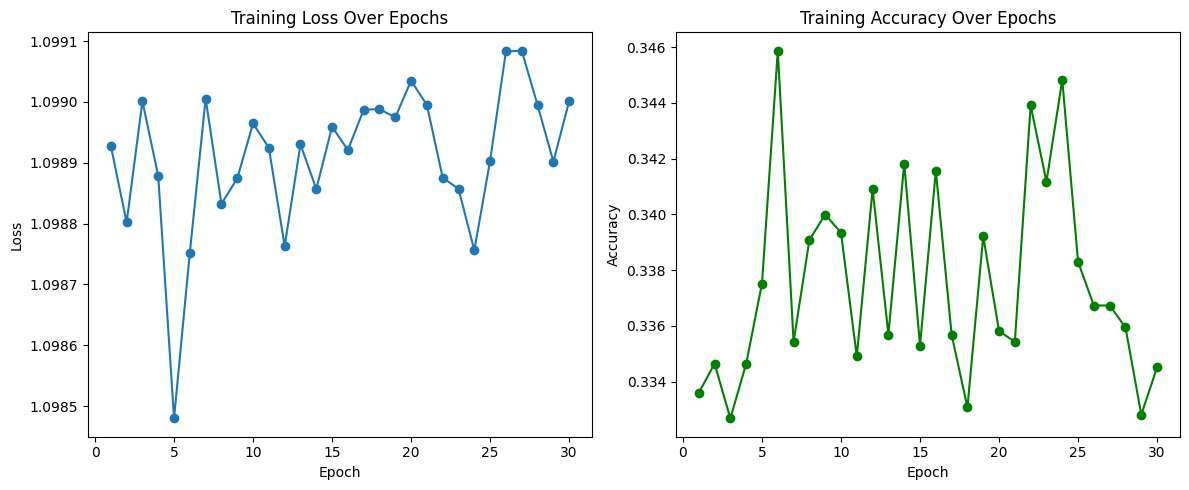

In [ ]:
# ===============================
# Plotting
# ===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 31), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 31), accuracies, marker='o', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

100%|██████████| 1915/1915 [00:06<00:00, 308.59it/s]


Test accuracy: 0.3368146214099217


(array([   0., 1915.,    0.]),
 array([1.5       , 1.83333333, 2.16666667, 2.5       ]),
 <BarContainer object of 3 artists>)

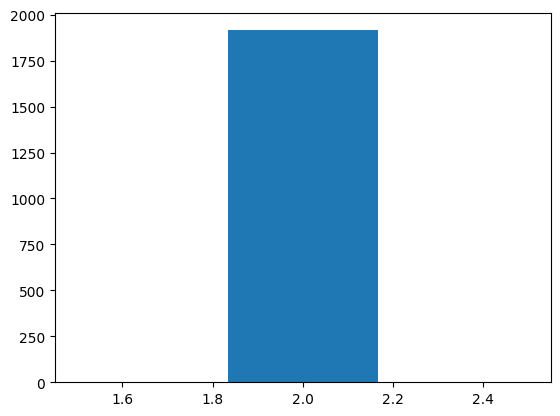

In [ ]:
# Test the model and display a histogram of the outputs
correct_predictions = 0
model_instance.eval()
predicted_classes = []
for test_point in tqdm(test_data):
    data_tensor = test_point.to(device)
    output = model_instance(data_tensor)
    if torch.argmax(output) == torch.argmax(data_tensor.y):  # if prediction is correct, increment counter for accuracy calculation
        correct_predictions += 1
    predicted_classes.append(torch.argmax(output).item())

print("Test accuracy: " + str(correct_predictions / len(test_data)))
plt.hist(predicted_classes, bins=3)

In [ ]:
# Test SMILES string
def evaluate_smiles(smiles_string):
    class_labels = ['insoluble', 'slightly soluble', 'soluble']
    graph = read_smiles(smiles_string, explicit_hydrogen=True)  # decode smiles string
    feature_vector = convert_element_to_onehot(np.asarray(graph.nodes(data='element'))[:, 1])  # convert element to one-hot vector
    edges = np.asarray(graph.edges)  # get edge array
    index_array = np.asarray([edges[:, 0], edges[:, 1]])  # reformat edge array to torch geometric suitable format
    data_instance = Data(x=torch.tensor(feature_vector, dtype=torch.float), edge_index=torch.tensor(index_array, dtype=torch.long))  # create torch geometry Data object
    data_instance = data_instance.to(device)  # send data to device memory
    model_instance.eval()  # set model to evaluate mode
    print(class_labels[torch.argmax(torch.softmax(model_instance(data_instance), dim=0)).item()])  # evaluate the test data

In [ ]:
evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O')  # test out the model on Vitamin C   soluble

soluble


In [ ]:
evaluate_smiles('CCCCCCCCCC') #insoluble

soluble


In [ ]:
evaluate_smiles('C(=O)(O)CCCCCCCCC(=O)(O)') #insoluble
evaluate_smiles('O=C(C1=C(OC(C)=O)C=CC=C1)O') #soluble
evaluate_smiles('c1ccccc1') #soluble
evaluate_smiles('CC(C)(C)c1ccc(C(C)(C)C)cc1') #insoluble

soluble
soluble
soluble
soluble


In [ ]:
evaluate_smiles('CCC(C)C1C(=O)NC2CSSCC(C(=O)NC(CSSCC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(CSSCC(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC2=O)CO)CC(C)C)CC3=CC=C(C=C3)O)CCC(=O)N)CC(C)C)CCC(=O)O)CC(=O)N)CC4=CC=C(C=C4)O)C(=O)NC(CC(=O)N)C(=O)O)C(=O)NCC(=O)NC(CCC(=O)O)C(=O)NC(CCCNC(=N)N)C(=O)NCC(=O)NC(CC5=CC=CC=C5)C(=O)NC(CC6=CC=CC=C6)C(=O)NC(CC7=CC=C(C=C7)O)C(=O)NC(C(C)O)C(=O)N8CCCC8C(=O)NC(CCCCN)C(=O)NC(C)C(=O)O)C(C)C)CC(C)C)CC9=CC=C(C=C9)O)CC(C)C)C)CCC(=O)O)C(C)C)CC(C)C)CC2=CN=CN2)CO)NC(=O)C(CC(C)C)NC(=O)C(CC2=CN=CN2)NC(=O)C(CCC(=O)N)NC(=O)C(CC(=O)N)NC(=O)C(C(C)C)NC(=O)C(CC2=CC=CC=C2)N)C(=O)NC(C(=O)NC(C(=O)N1)CO)C(C)O)NC(=O)C(CCC(=O)N)NC(=O)C(CCC(=O)O)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)CN')
# insoluble

soluble


In [ ]:
# Save the model
model_path = 'trained_graph_network.pth'  # Specify the path where you want to save the model
torch.save(model_instance.state_dict(), model_path)  # Save the model's state_dict
print(f'Model saved to {model_path}')

Model saved to trained_graph_network.pth


In [ ]:
!cp -f trained_graph_network.pth /content/drive/MyDrive/Deep_Learning/

In [ ]:
!pwd

/content


In [ ]:
!ls

curated-solubility-dataset.csv	sample_data  trained_graph_network.pth


# Transformers

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import os
os.environ["WANDB_DISABLED"] = "true"

# 2. Load and label data
df = pd.read_csv('/content/drive/MyDrive/Deep_Learning/curated-solubility-dataset.csv')
def solubility_to_class(val):
    if val < -3.65: return 0
    elif val < -1.69: return 1
    else: return 2
df['label'] = df['Solubility'].apply(solubility_to_class)

# 3. Train/test split
train_df, test_df = train_test_split(df[['SMILES', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

# 4. Load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 5. Custom dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, labels):
        self.smiles = smiles
        self.labels = labels

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        encoding = tokenizer(self.smiles[idx], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return encoding

train_dataset = SMILESDataset(train_df['SMILES'].tolist(), train_df['label'].tolist())
test_dataset = SMILESDataset(test_df['SMILES'].tolist(), test_df['label'].tolist())

# 6. Training arguments
training_args = TrainingArguments(
    output_dir="./chemberta_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# 7. Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# 8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 9. Train
trainer.train()

# 10. Evaluate
eval_results = trainer.evaluate()
print("Final Test Accuracy:", eval_results["eval_accuracy"])

# 11. Classification report
preds = trainer.predict(test_dataset)
y_true = test_df['label'].tolist()
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred, target_names=["Insoluble", "Slightly Soluble", "Soluble"]))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.794500,0.674205,0.693540
2,0.612300,0.607621,0.740110
3,0.512800,0.594429,0.753130
4,0.447200,0.589986,0.764647
5,0.396900,0.602668,0.762644


Final Test Accuracy: 0.7646469704556835
                  precision    recall  f1-score   support

       Insoluble       0.83      0.81      0.82       666
Slightly Soluble       0.67      0.69      0.68       667
         Soluble       0.80      0.80      0.80       664

        accuracy                           0.76      1997
       macro avg       0.77      0.76      0.77      1997
    weighted avg       0.77      0.76      0.77      1997



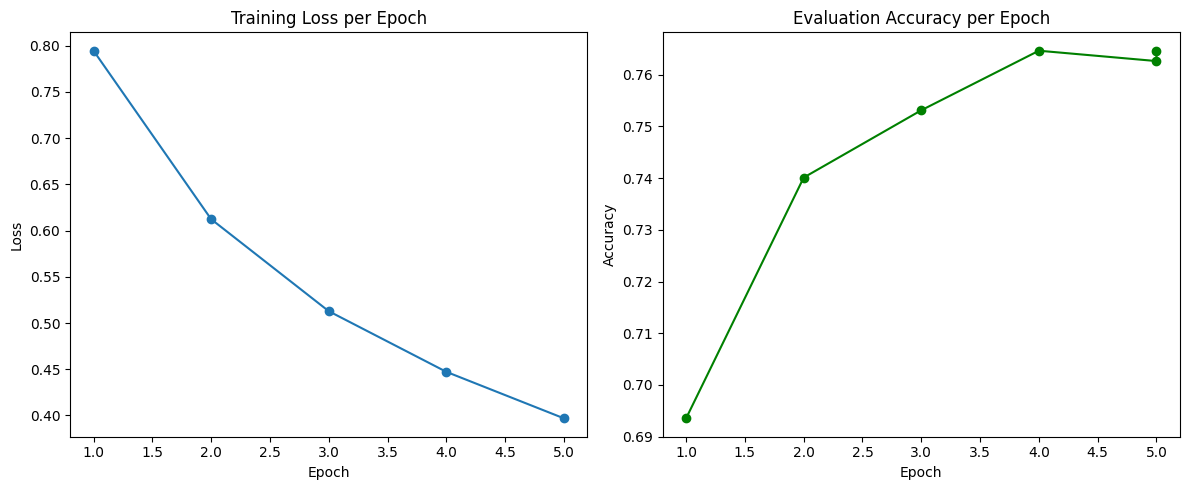

In [ ]:
# Extract loss and accuracy logs properly
epochs_loss = []
train_loss = []
epochs_acc = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        epochs_loss.append(log["epoch"])
        train_loss.append(log["loss"])
    if 'eval_accuracy' in log and 'epoch' in log:
        epochs_acc.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Plot loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_loss, train_loss, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_acc, eval_accuracy, marker='o', color='green')
plt.title("Evaluation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


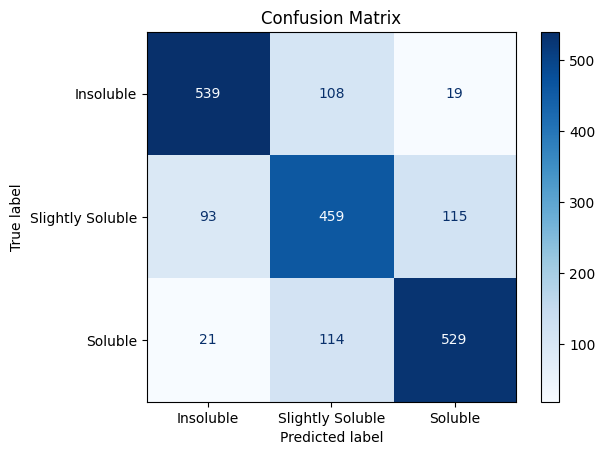

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define class names
class_names = ["Insoluble", "Slightly Soluble", "Soluble"]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 12. Save the model and tokenizer
model_path = "./chemberta_model_final"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to: {model_path}")

Model and tokenizer saved to: ./chemberta_model_final


In [ ]:
!mkdir -p /content/drive/MyDrive/Models/chemberta-solubility

In [ ]:
# save it in drive
model.save_pretrained("/content/drive/MyDrive/Models/chemberta-solubility")
tokenizer.save_pretrained("/content/drive/MyDrive/Models/chemberta-solubility")

('/content/drive/MyDrive/Models/chemberta-solubility/tokenizer_config.json',
 '/content/drive/MyDrive/Models/chemberta-solubility/special_tokens_map.json',
 '/content/drive/MyDrive/Models/chemberta-solubility/vocab.json',
 '/content/drive/MyDrive/Models/chemberta-solubility/merges.txt',
 '/content/drive/MyDrive/Models/chemberta-solubility/added_tokens.json',
 '/content/drive/MyDrive/Models/chemberta-solubility/tokenizer.json')

# UI

In [ ]:
!pip install streamlit torch transformers

1. source DL_assignment/Scripts/activate
  --- pip install -r req.txt --> only once
2. streamlit run app.py

In [ ]:
import streamlit as st
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -------------------------------
# Load model and tokenizer
# -------------------------------
MODEL_PATH = "./chemberta-solubility"  # Update if saved elsewhere

@st.cache_resource
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
    model.eval()
    return tokenizer, model

tokenizer, model = load_model()

# -------------------------------
# Define classes
# -------------------------------
class_labels = ["Insoluble", "Slightly Soluble", "Soluble"]

# -------------------------------
# Streamlit UI
# -------------------------------
st.title("ChemBERTa Solubility Predictor")
st.write("Enter a **SMILES string** to predict its solubility class.")

# Input
smiles_input = st.text_input("SMILES String:", value="CC(=O)Oc1ccccc1C(=O)O")

if st.button("Predict"):
    if not smiles_input.strip():
        st.warning("Please enter a valid SMILES string.")
    else:
        with st.spinner("Predicting..."):
            # Tokenize
            inputs = tokenizer(smiles_input, return_tensors="pt", truncation=True, padding=True, max_length=128)
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1).squeeze().numpy()
                predicted_class = np.argmax(probs)

        # Display results
        st.success(f"**Predicted Solubility Class:** {class_labels[predicted_class]}")
        st.markdown("**Model Confidence:**")
        confidence_chart = {label: float(probs[i]) for i, label in enumerate(class_labels)}
        st.bar_chart(confidence_chart)

# Footer
st.markdown("---")
st.markdown("Created with using ChemBERTa and Streamlit")
